## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
#import xgboost as xgb
import seaborn as sns
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from subprocess import check_call
from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls

## Loading the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Storing the test passenger Id for easy access

In [3]:
passenger_ID = test['PassengerId']

In [4]:
# overview of the train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# copy the train data for future use
original_train = train.copy()

In [6]:
full_data = [train,test]

In [7]:
full_data

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

In [8]:
# features that tell whether passenger had a cabin on titanic ?
train['Has_cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

#train['Has_cabin']
#np.isnan(test['Has_cabin']).any()

In [9]:
# Creating new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp']+ dataset['Parch']+1
    
# Creating new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']== 1, 'IsAlone'] = 1
    

In [10]:
# Removing all the NULL from Embarked and Fare Column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [11]:
for dataset in full_data:
    dataset['Fare']= dataset['Fare'].fillna(train['Fare'].median())

In [12]:
# Removing all the NULL from Age Column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    
dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
dataset['Age']= dataset['Age'].astype(int)

#train= dataset
#test = dataset
#np.isnan(train['Age']).any()

In [13]:
# Define Function to extract titles from passenger name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [14]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [15]:
# Group all non-common titles in one group
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess', 'Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    

In [16]:
for dataset in full_data:
    
    # mapping sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).fillna(0).astype(int)
    
    # mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)    
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).fillna(0).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].fillna(0).astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] 
    
#np.isnan(train['Has_cabin']).any()

In [17]:
# Feature Selection - removing variables which do not contain information

drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis=1)
test = test.drop(drop_elements, axis=1)

### Visualizing Processed Data

In [18]:
train.head(10)
#np.isnan(train['Age']).any()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_cabin,FamilySize,IsAlone,Title
0,0,3,1,1.0,0,0,0,0,2,0,1
1,1,1,0,2.0,0,3,1,1,2,0,3
2,1,3,0,1.0,0,1,0,0,1,1,4
3,1,1,0,2.0,0,3,0,1,2,0,3
4,0,3,1,2.0,0,1,0,0,1,1,1
5,0,3,1,NaN,0,1,2,0,1,1,1
6,0,1,1,3.0,0,3,0,1,1,1,1
7,0,3,1,0.0,1,2,0,0,5,0,2
8,1,3,0,1.0,2,1,0,0,3,0,3
9,1,2,0,0.0,0,2,1,0,2,0,3


In [19]:
df = pd.DataFrame(train)

df = df.apply (pd.to_numeric, errors='coerce')
df = df.dropna()
df = df.reset_index(drop=True)
print (df)


df1 = pd.DataFrame(test)

df1 = df1.apply (pd.to_numeric, errors='coerce')
df1 = df1.dropna()
df1 = df1.reset_index(drop=True)
print (df1)

     Survived  Pclass  Sex  Age  Parch  Fare  Embarked  Has_cabin  FamilySize  \
0           0       3    1  1.0      0     0         0          0           2   
1           1       1    0  2.0      0     3         1          1           2   
2           1       3    0  1.0      0     1         0          0           1   
3           1       1    0  2.0      0     3         0          1           2   
4           0       3    1  2.0      0     1         0          0           1   
..        ...     ...  ...  ...    ...   ...       ...        ...         ...   
709         0       3    0  2.0      5     2         2          0           6   
710         0       2    1  1.0      0     1         0          0           1   
711         1       1    0  1.0      0     2         0          1           1   
712         1       1    1  1.0      0     2         1          1           1   
713         0       3    1  1.0      0     0         2          0           1   

     IsAlone  Title  
0    

In [20]:
np.isnan(df['Age']).any()

False

In [21]:
# Remove Columns with null value
# cols_with_missing = [col for col in train.columns if train[col].isnull().any()] 
# train.drop(cols_with_missing, axis=1, inplace=True)

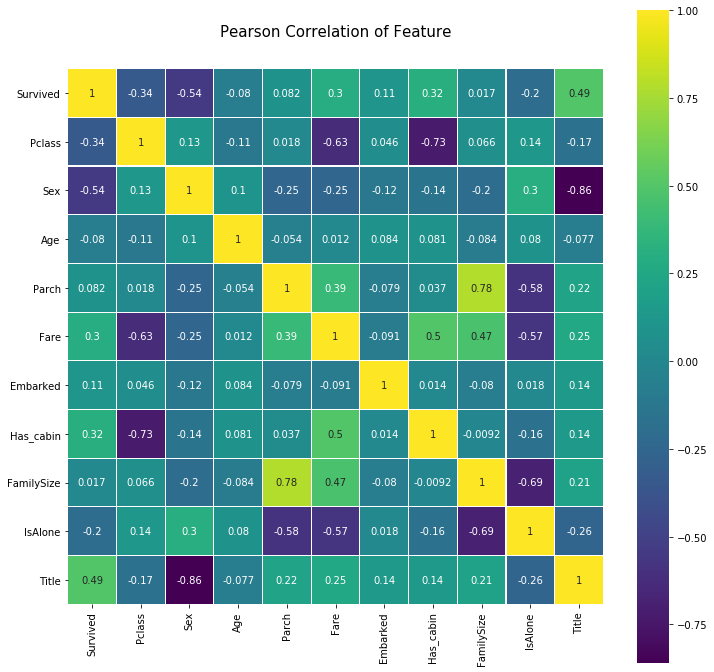

In [22]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Feature', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Title and Sex

In [23]:
df[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean','count','sum'])

Survived           
           mean count  sum
Title                     
1      0.168342   398   67
2      0.583333    36   21
3      0.788991   109   86
4      0.724832   149  108
5      0.363636    22    8

In [24]:
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean','count','sum'])

Survived           
         mean count  sum
Sex                     
0    0.754789   261  197
1    0.205298   453   93

In [25]:
title_and_sex = original_train.copy()[['Name','Sex']]

# create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

title_and_sex['Sex'] = title_and_sex['Sex'].map({'female': 0, 'male': 1} ).fillna(0).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])


#print(df)

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

In [26]:
# Gini Impurity

def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [27]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [28]:
# for second node split

# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [29]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [30]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

In [31]:
# Gini Impurity decrease of node for observations with Title == 1 == Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1


0.26425329886377663

In [32]:
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [33]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

print(df)

     Survived  Pclass  Sex  Age  Parch  Fare  Embarked  Has_cabin  FamilySize  \
0           0       3    1  1.0      0     0         0          0           2   
1           1       1    0  2.0      0     3         1          1           2   
2           1       3    0  1.0      0     1         0          0           1   
3           1       1    0  2.0      0     3         0          1           2   
4           0       3    1  2.0      0     1         0          0           1   
..        ...     ...  ...  ...    ...   ...       ...        ...         ...   
709         0       3    0  2.0      5     2         2          0           6   
710         0       2    1  1.0      0     1         0          0           1   
711         1       1    0  1.0      0     2         0          1           1   
712         1       1    1  1.0      0     2         1          1           1   
713         0       3    1  1.0      0     0         2          0           1   

     IsAlone  Title  
0    

### K-fold Cross Validation

In [34]:
cv = KFold(n_splits=10)

In [35]:
accuracies = list()
max_attributes = len(list(df1))
depth_range = range(1, max_attributes+1)

#print(df1)

In [36]:
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    
    
    for train_fold, valid_fold in cv.split(df):
        f_train = df.loc[train_fold]   # Extract train data from cv indices
        f_valid = df.loc[valid_fold]   # Extract valid data from cv indices
        
        
        f_train = f_train.fillna(f_train.mean(), inplace=False)
        
        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), y=f_train["Survived"])
        valid_acc = model.score(X = f_train.drop(['Survived'], axis=1), y=f_train["Survived"])
        fold_accuracy.append(valid_acc)
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

In [37]:
# to show the results
print(len(depth_range))
print(len(accuracies))
df3 = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy":accuracies})
df3 = df3[["Max Depth", "Average Accuracy"]]
print(df3.to_string(index=False))


10
10
 Max Depth  Average Accuracy
         1          0.776843
         2          0.795208
         3          0.823840
         4          0.842049
         5          0.856678
         6          0.866949
         7          0.876130
         8          0.885000
         9          0.893246
        10          0.899316


### Final Tree

In [38]:
# Create numpy array of train

y_train = df['Survived'].values
x_train = df.drop(['Survived'], axis = 1).values
x_test = df1.values

In [39]:
# Create Decision Tree with depth 3
#  x_train = x_train.reshape(-1,1)
decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(x_train, y_train)
# print(x_train)
# print(y_train)

# accu_train = np.sum(decision_tree.predict(x_train.values.reshape(-1, 1)) == y_train)/y_train_size
# accu_test = np.sum(decision_tree.predict(x_test.values.reshape(-1, 1)) == y_test)/y_test_size

# print("Accuracy on Train: ", accu_train)
# print("Accuracy on Test: ", accu_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [40]:
# Predicting results for test datasets
x_test
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({'PassengerId': passenger_ID, 'Survived':y_pred})
submission.to_csv('submission.csv', index=False)

In [41]:
# Export our trained data as a dotfile

with open("tree1.dot","w") as f:
    f = tree.export_graphviz(decision_tree, out_file=f,max_depth=3, impurity=True, feature_names=list(df.drop(['Survived'], axis=1)), class_names=['Died','Survived'], rounded=True, filled=True)

In [42]:
#convert .dot to .png to allow display in web notebook

check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

0

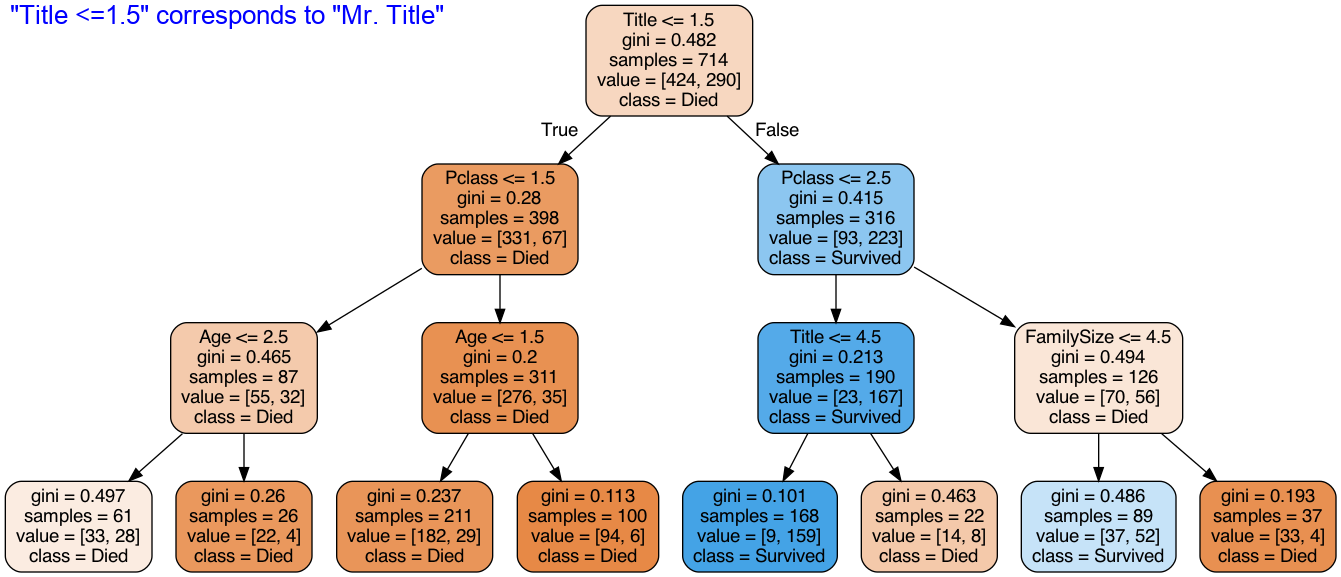

In [50]:
#Annotation chart with PIL

img= Image.open('tree1.png')
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('Arial.ttf', 26)
draw.text((10,0),# Drawing offset(position)  
         '"Title <=1.5" corresponds to "Mr. Title"',
         (0,0,255), # Desired Color
         font=font)
img.save('Sample-output.png')
PImage('Sample-output.png')

        

In [51]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.49